## Prep

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import to_long_format
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter
import random
import matplotlib.pyplot as plt
import statistics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from lifelines.statistics import logrank_test
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

In [2]:
dat = pd.read_csv('data/jhs_preprocess_0914.csv')

dat['event'] = 0

### calculate time

In [3]:
dat['time'] = ''

dat_v1 = dat.loc[dat['visit'] == 1, ['subjid','VisitDate']].rename(columns={'VisitDate': 't1'})
dat_v2 = dat.loc[dat['visit'] == 2, ['subjid','VisitDate']].rename(columns={'VisitDate': 't2'})
dat_v3 = dat.loc[dat['visit'] == 3, ['subjid','VisitDate']].rename(columns={'VisitDate': 't3'})

dat_v1.reset_index(drop=True, inplace=True)
dat_v2.reset_index(drop=True, inplace=True)
dat_v3.reset_index(drop=True, inplace=True)

dat_t12 = pd.concat([dat_v1, dat_v2], axis=1)
dat_time = pd.concat([dat_t12, dat_v3], axis=1)

In [4]:
dat_time['t1'] = pd.to_datetime(dat_time['t1'])
dat_time['t2'] = pd.to_datetime(dat_time['t2'])
dat_time['t3'] = pd.to_datetime(dat_time['t3'])

dat_time['time_12'] = dat_time['t2'] - dat_time['t1']
dat_time['time_13'] = dat_time['t3'] - dat_time['t1']

dat_time = dat_time.iloc[:,[0,-2,-1]]
dat_time['time_12'] = (dat_time['time_12'] / pd.Timedelta(days=1)).astype(int)
dat_time['time_13'] = (dat_time['time_13'] / pd.Timedelta(days=1)).astype(int)

In [5]:
dat = pd.merge(dat,dat_time, on='subjid')
dat

,subjid,visit,nSES,nbSESpc2score,nbK3paFacilities,currentSmoker,Diabetes,sex,age,sbp,hdl,totchol,MIHx,strokeHx,CHDHx,CVDHx,N_UNFAV_CT00,G_bla_rk,VisitDate,nutrition3cat,PA3cat,fmlyinc,alc,gender,y,event,time,time_12,time_13
0,J100079,1,0.0,2.0,3.0,0.0,1.0,Female,62,-1.485405,0.950038,2.168660,0.0,0.0,0.0,0.0,4.0,2.0,01/22/2001,1.0,1.0,1.0,1.0,0,0,0,,1806,2975
1,J100079,2,NaN,NaN,NaN,NaN,1.0,Female,67,-0.857379,NaN,NaN,0.0,0.0,NaN,0.0,4.0,2.0,01/02/2006,NaN,NaN,NaN,NaN,0,0,0,,1806,2975
2,J100079,3,NaN,NaN,NaN,NaN,1.0,Female,70,-0.841121,0.965273,NaN,0.0,0.0,0.0,0.0,NaN,NaN,03/16/2009,NaN,0.0,3.0,0.0,0,0,0,,1806,2975
3,J100180,1,1.0,4.0,2.0,0.0,0.0,Female,75,-0.215153,1.385300,1.192832,0.0,0.0,0.0,0.0,1.0,3.0,02/24/2001,1.0,1.0,2.0,0.0,0,0,0,,1749,4220
4,J100180,2,NaN,NaN,NaN,NaN,0.0,Female,79,0.242361,NaN,NaN,0.0,0.0,NaN,0.0,2.0,3.0,12/09/2005,NaN,NaN,NaN,NaN,0,0,0,,1749,4220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10699,J599323,2,NaN,NaN,NaN,NaN,0.0,Female,52,-0.034619,49.000000,NaN,0.0,0.0,NaN,0.0,3.0,1.0,12/10/2007,NaN,NaN,NaN,NaN,0,0,0,,1350,2582
10700,J599323,3,NaN,NaN,NaN,NaN,0.0,Female,55,0.593140,-0.138327,NaN,0.0,0.0,0.0,0.0,NaN,NaN,04/25/2011,NaN,0.0,3.0,0.0,0,0,0,,1350,2582
10701,J599797,1,1.0,3.0,4.0,0.0,0.0,Female,50,0.015974,1.167669,1.377448,0.0,0.0,0.0,0.0,4.0,3.0,03/29/2004,0.0,1.0,4.0,1.0,0,0,0,,1328,2561
10702,J599797,2,NaN,NaN,NaN,NaN,0.0,Female,54,1.110376,60.000000,NaN,0.0,0.0,NaN,0.0,4.0,3.0,11/17/2007,NaN,NaN,NaN,NaN,0,0,0,,1328,2561


## baseline model

### prep

In [6]:
## get all the covariates from V1, combine with outcome from 3 visits
dat_v1 = dat[dat['visit'] == 1]
dat_v2 = dat.loc[dat['visit'] == 2, ['subjid','y']].rename(columns={'y': 'y2'})
dat_v3 = dat.loc[dat['visit'] == 3, ['subjid','y']].rename(columns={'y': 'y3'})

merged_df = pd.merge(dat_v1, dat_v2, on='subjid')
merged_df = pd.merge(merged_df, dat_v3, on='subjid')

merged_df['time'] = merged_df['time_13']  # because most subjects were right censored

In [7]:
dat_base = merged_df

## incidence in V1
dat_base.loc[dat_base['y'] == 1,'event'] = 1
dat_base.loc[dat_base['y'] == 1,'time'] = 0

## incidence in V2
v2_index = (dat_base['y2'] == 1) & (dat_base['y'] == 0)
dat_base.loc[v2_index,'event'] = 1
dat_base.loc[v2_index, 'time'] = dat_base.loc[v2_index, 'time_12']

## incidence in V1
v3_index = (dat_base['y3'] == 1) & (dat_base['y'] == 0) & (dat_base['y2'] == 0)
dat_base.loc[v3_index,'event'] = 1
dat_base.loc[v3_index, 'time'] = dat_base.loc[v3_index, 'time_13']

In [8]:
# convert categorical variables for auto dummy 

cols_to_convert = ['nbSESpc2score', 'N_UNFAV_CT00','nbK3paFacilities', 'G_bla_rk',
                   'PA3cat','nutrition3cat',
                   'gender', 'currentSmoker', 'Diabetes','alc','fmlyinc']
dat_base[cols_to_convert] = dat_base[cols_to_convert].astype('category')

### fit

In [10]:
cph_base = CoxPHFitter()
cph_base.fit(dat_base, duration_col='time', event_col='event',
       formula = "nbSESpc2score+nbK3paFacilities+N_UNFAV_CT00+G_bla_rk+ \
                 PA3cat+nutrition3cat+\
                 age+gender+currentSmoker+Diabetes+hdl+sbp+totchol+alc+fmlyinc")


<lifelines.CoxPHFitter: fitted with 3568 total observations, 3104 right-censored observations>

In [11]:
cph_base.print_summary()

<lifelines.CoxPHFitter: fitted with 3568 total observations, 3104 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3568
number of events observed = 464
   partial log-likelihood = -3499.53
         time fit was run = 2023-09-15 00:49:03 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Diabetes[T.1.0]           0.68       1.98       0.10             0.49             0.88                 1.63                 2.41
G_bla_rk[T.2.0]           0.44       1.55       0.17             0.11             0.77                 1.11                 2.16
G_bla_rk[T.3.0]           0.45       1.57       0.18             0.10             0.81                 1.10                 2.25
G_bla_rk[T.4.0]           0.48       1.62       0.17             0.14             0.82                 1.15                 2.28
N_UNFAV_CT00[T.2.0]       0.09       1.10       0.14            -0.17             0.36                 0.84                 1.43
N_UNFAV_CT00[T.3.0]       0.15       1.16       0.14            -0.13             0.43                 0.88                 1.53
N_UNFAV_CT00[T.4.0]       0.12       1.13       0.14            -0.15             0.40                 0.86                 1.49
PA3cat[T.1.0]            -0.11       0.89       0.11            -0.33             0.11                 0.72                 1.11
PA3cat[T.2.0]            -0.05       0.95       0.14            -0.32             0.22                 0.73                 1.24
age                       0.05       1.05       0.00             0.04             0.06                 1.04                 1.06
alc[T.1.0]               -0.03       0.97       0.10            -0.23             0.18                 0.79                 1.19
currentSmoker[T.1.0]      0.56       1.75       0.14             0.29             0.83                 1.34                 2.28
fmlyinc[T.2.0]           -0.16       0.85       0.15            -0.46             0.14                 0.63                 1.15
fmlyinc[T.3.0]           -0.27       0.76       0.14            -0.55             0.00                 0.58                 1.00
fmlyinc[T.4.0]           -0.23       0.80       0.19            -0.61             0.15                 0.55                 1.16
gender[T.1]               0.22       1.25       0.11             0.01             0.43                 1.01                 1.54
hdl                      -0.05       0.95       0.05            -0.15             0.05                 0.86                 1.05
nbK3paFacilities[T.2.0]  -0.32       0.73       0.15            -0.61            -0.03                 0.54                 0.97
nbK3paFacilities[T.3.0]  -0.20       0.82       0.15            -0.49             0.09                 0.61                 1.09
nbK3paFacilities[T.4.0]  -0.16       0.85       0.15            -0.46             0.13                 0.63                 1.14
nbSESpc2score[T.2.0]      0.17       1.19       0.16            -0.14             0.48                 0.87                 1.62
nbSESpc2score[T.3.0]      0.05       1.05       0.16            -0.26             0.35                 0.77                 1.42
nbSESpc2score[T.4.0]      0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
nutrition3cat[T.1.0]      0.04       1.04       0.10            -0.16             0.24                 0.85                 1.28
nutrition3cat[T.2.0]     -0.07       0.93       0.39            -0.83             0.68                 0.43                 1.98
sbp                       0.13       1.14       0.04             0.05             0.22                 1.05                 1.25
totchol                  -0

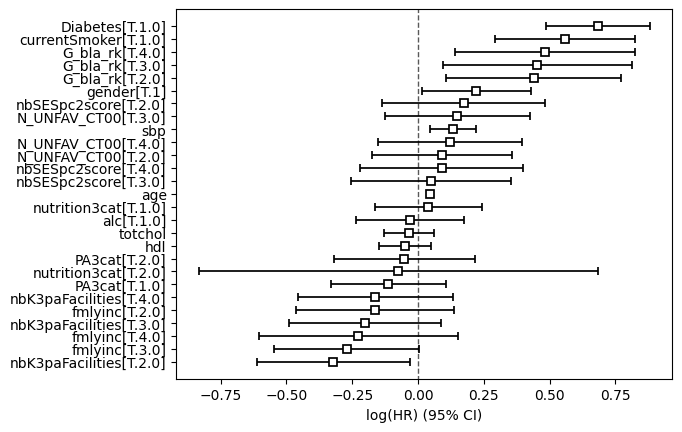

In [12]:
cph_base.plot()
plt.show()

## time-varying covariates

### prep

In [ ]:
# V1 in long format

dat_tv1 = dat[dat['visit'] == 1]

dat_tv1 = to_long_format(dat_tv1, duration_col="visit")
dat_tv1 = dat_tv1.drop('event', axis=1)
dat_tv1 = dat_tv1.rename(columns={'y': 'event'})

In [ ]:
# V2

dat_tv2 = dat.loc[dat['visit'] == 2].rename(columns={'y': 'y2'})

## get value from V1 if covariates not available at V2
dat_tv2 = dat_tv2[['subjid','visit','Diabetes','age','sbp','N_UNFAV_CT00','G_bla_rk','gender','y2']]
covar_from_V1 = dat_tv1[['subjid','nbSESpc2score', 'nbK3paFacilities',
                        'sportIndex','hyIndex','activeIndex','darkgrnVeg', 'eggs','fish',
                        'currentSmoker', 'hdl','totchol']]
dat_tv2 = dat_tv2.merge(covar_from_V1, on = 'subjid', how = 'left', suffixes=(False, False))

## manually add "start" and "stop" col
dat_tv2 = dat_tv2.rename(columns={'y2': 'event', 'visit':'stop'})
dat_tv2['start'] = 1

In [ ]:
# V3

dat_tv3 = dat.loc[dat['visit'] == 3].rename(columns={'y': 'y3'})

## get value from V1 if covariates not available at V2
dat_tv3 = dat_tv3[['subjid','visit','y3',
                   'sportIndex','hyIndex','activeIndex',
                   'Diabetes','age','sbp','hdl','gender']]
covar_from_V2 = dat_tv2[['subjid','N_UNFAV_CT00','G_bla_rk']]
covar_from_V1 = dat_tv1[['subjid','nbSESpc2score', 'nbK3paFacilities',
                        'darkgrnVeg', 'eggs','fish',
                        'currentSmoker', 'totchol']]
dat_tv3 = dat_tv3.merge(covar_from_V2, on = 'subjid', how = 'left', suffixes=(False, False))
dat_tv3 = dat_tv3.merge(covar_from_V1, on = 'subjid', how = 'left', suffixes=(False, False))

## manually add "start" and "stop" col
dat_tv3 = dat_tv3.rename(columns={'y3': 'event', 'visit':'stop'})
dat_tv3['start'] = 2

In [ ]:
# merge

dat_tv12 = pd.concat([dat_tv1, dat_tv2])
dat_tv123 = pd.concat([dat_tv12, dat_tv3])
dat_tv = dat_tv123.sort_values(by=['subjid'])
dat_tv = dat_tv.loc[:,['subjid', 'event','start','stop',
                       'nbSESpc2score', 'nbK3paFacilities','N_UNFAV_CT00', 'G_bla_rk',
                   'sportIndex','hyIndex','activeIndex','darkgrnVeg', 'eggs','fish', 
                   'age','gender', 'currentSmoker', 'Diabetes','sbp','hdl','totchol']]


In [ ]:
# dummy coding
cols_to_convert = ['nbSESpc2score', 'nbK3paFacilities','N_UNFAV_CT00', 'G_bla_rk',
                   'sportIndex','hyIndex','activeIndex','darkgrnVeg', 'eggs','fish', 
                   'gender', 'currentSmoker', 'Diabetes']

dat_tv[cols_to_convert] = dat_tv[cols_to_convert].astype('category')

dummy_cols = pd.get_dummies(dat_tv[cols_to_convert])
dat_tv = dat_tv.drop(cols_to_convert, axis=1)
dat_tv = pd.concat([dat_tv, dummy_cols], axis=1)
dat_tv

### fit

In [ ]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(dat_tv, id_col="subjid",event_col="event", start_col="start", stop_col="stop", show_progress=False)
ctv.print_summary()